This notebook provides a summary of the predictive analyses using task or survey data to predict demographic/health measures.  

In [13]:
import os,glob,sys
import pickle
import numpy,pandas
pandas.options.display.max_colwidth = 0
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
import seaborn as sns
import scipy.stats
from statsmodels.sandbox.stats.multicomp import multipletests

import selfregulation.prediction.behavpredict as behavpredict

clf='lasso'
acc,features=pickle.load(open('singularity_analyses/wrangler/%s_data_collapsed.pkl'%clf,'rb'))
cont_measure='r2' # use r^2 or MAE for non-binary variables

In [14]:
acc['baseline'][cont_measure]['scores_cv'].shape

(1000, 45)

   Create tables summarizing data

In [15]:
allvars={}
for k in acc.keys():
    if len(acc[k])==0:
        print('no data for',k)
        continue
    for v in acc[k][cont_measure]['scores_cv']:
        allvars[v]=cont_measure
    for v in acc[k]['AUROC']['scores_cv']:
        allvars[v]='AUROC'

alldata={'r2':pandas.DataFrame(),'MAE':pandas.DataFrame(),'AUROC':pandas.DataFrame(),
        'r2_pval':pandas.DataFrame()}
datasets=['baseline_shuffle','baseline','task','survey','discounting','stopping','intelligence',
          'impulsivity','big5','risktaking','grit','emotion_regulation','bisbas']
for v in allvars:
    if allvars[v]==cont_measure:
        vars={}
        for k in datasets:
            if not 'r2' in acc[k]:
                continue
            vars[k]=acc[k]['r2']['scores_cv'].mean().T
        df=pandas.DataFrame(vars,index=[v])
        alldata['r2']=alldata['r2'].append(df)
        
        vars={}
        for k in datasets:
            if not 'MAE' in acc[k]:
                continue
            vars[k]=acc[k]['MAE']['scores_cv'].mean().T
        df=pandas.DataFrame(vars,index=[v])
        alldata['MAE']=alldata['MAE'].append(df)
    else:
        vars={}
        for k in datasets:
            if not 'AUROC' in acc[k]:
                continue
            vars[k]=acc[k]['AUROC']['scores_cv'].mean().T
        df=pandas.DataFrame(vars,index=[v])
        alldata['AUROC']=alldata['AUROC'].append(df)
   


no data for emotion_regulation


Compute p values

In [16]:
target='baseline'
null='baseline_shuffle'
def get_pval(target,null,allvars,datasets,acc):
    data=[]
    vars=list(allvars.keys())
    vars.sort()
    for v in vars:
        #print(target,null,v)
        if not v in acc[target][allvars[v]]['scores_cv'] or not v in acc[null][allvars[v]]['scores_cv']:
            data.append([allvars[v],numpy.nan,numpy.nan,numpy.nan,numpy.nan,numpy.nan])
            continue
        targdist=acc[target][allvars[v]]['scores_cv'][v].dropna()
        targmean=targdist.mean()
        nulldist=acc[null][allvars[v]]['scores_cv'][v].dropna()
        nullmean=nulldist.mean()
        targstd=targdist.std()
        pval=1-scipy.stats.percentileofscore(nulldist,targmean)/100.
        if targstd>0:
            es=(targmean-nullmean)/targstd
        else:
            es=numpy.nan
        insample=acc[target][allvars[v]]['scores_insample'][v].mean()
        data.append([allvars[v],targmean,nullmean,es,insample,pval])
    df=pandas.DataFrame(data,index=vars,columns=['Measure','Target mean','Null Mean','Effect size','In-sample','p_unc'])
    return(df)
        
pvals={}
pvals[('baseline','baseline_shuffle')]=get_pval('baseline','baseline_shuffle',allvars,datasets,acc)
for d in datasets:
    if d.find('baseline')>-1 or len(acc[d])==0:
        continue
    print(d)
    pvals[(d,'baseline')]=get_pval(d,'baseline',allvars,datasets,acc)

pvals_fdr={}
for k in pvals:
    tmp=multipletests(pvals[k]['p_unc'])
    pvals[k]['p_fdr']=tmp[1]

task
survey
discounting
stopping
intelligence
impulsivity
big5
risktaking
grit
bisbas


In [17]:
def get_importances(v,dt,features,nfeats=3):
    if not v in features[dt]:
        print(v,'is not in features for',dt)
        return None
    
    #print(dt,'importances for:',v)
    imp=pandas.DataFrame({'importance':features[dt][v].mean(0)}).abs().sort_values(by='importance',ascending=False)
    
    if nfeats>(imp.shape[0]):
        nfeats=imp.shape[0]
    topfeats=imp.iloc[:nfeats]
    topfeats=topfeats.query('importance>0')
    return topfeats

def get_importance_list(sigp,dt,features):
    implist=[]
    for v in sigp.index:
        i=get_importances(v,dt,features)
        implist.append([list(i.index)])
    df=pandas.DataFrame({'top features':implist})
    df.index=sigp.index
    return df

# plot var for all datasets
def plotvars(v,pvals,datasets,allvars):

    df=[]
    errors=[]
    ds=[]
    for k in datasets:
        if not allvars[v] in acc[k]:
            continue
        if not v in acc[k][allvars[v]]['scores_cv']:
            continue
        targdist=acc[k][allvars[v]]['scores_cv'][v].dropna()
        df.append(targdist.mean())
        ds.append(k)
        errors.append(targdist.std())
    df=pandas.DataFrame({'mean':df},index=ds)
    errors=pandas.DataFrame({'mean':errors},index=ds)
    if allvars[v]=='AUROC':
        df.plot.bar(yerr=errors,legend=False,ylim=(0.45,numpy.max(df.values)*1.1))
    else:
        df.plot.bar(yerr=errors,legend=False)
    plt.title(v)
    plt.ylabel(allvars[v]+' +/- SE across CV runs')


## List all variables showing activity greater for baseline model vs shuffled model

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
Age,r2,1.000000,0.002725,1.964625e+10,1.000000,0.0,0.0,[[Age]]
HeightInches,r2,0.379079,0.002766,1.093295e+02,0.386995,0.0,0.0,"[[Sex, Age]]"
LongestRelationship,r2,0.266990,0.002867,9.211835e+01,0.274270,0.0,0.0,"[[Age, Sex]]"
RelationshipStatus.binarized,AUROC,0.620443,0.499214,6.444747e+01,0.620942,0.0,0.0,"[[Sex, Age]]"
RelationshipNumber,r2,0.154400,0.002797,4.253628e+01,0.162293,0.0,0.0,"[[Age, Sex]]"
DivorceCount.binarized,AUROC,0.736803,0.499135,3.133526e+01,0.550549,0.0,0.0,"[[Age, Sex]]"
ChildrenNumber,r2,0.127762,0.002880,3.132100e+01,0.138087,0.0,0.0,"[[Sex, Age]]"
ChildrenNumber.binarized,AUROC,0.696507,0.497903,2.992524e+01,0.646312,0.0,0.0,"[[Age, Sex]]"
TrafficAccidentsLifeCount.binarized,AUROC,0.611300,0.498427,2.398425e+01,0.611710,0.0,0.0,"[[Age, Sex]]"
RentOwn,AUROC,0.609530,0.500105,2.382382e+01,0.547859,0.0,0.0,"[[Age, Sex]]"


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


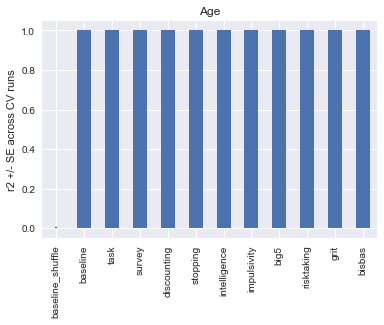

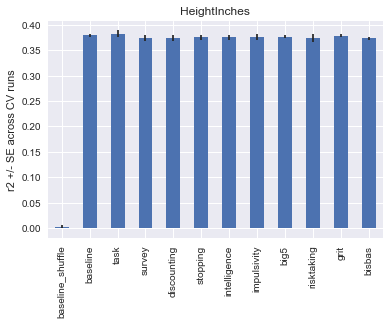

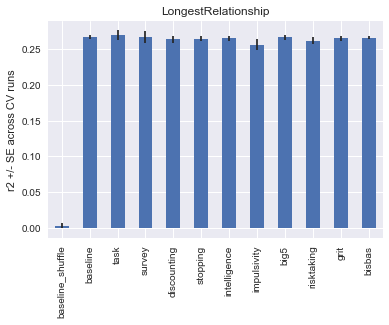

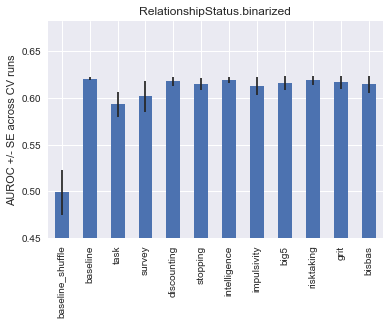

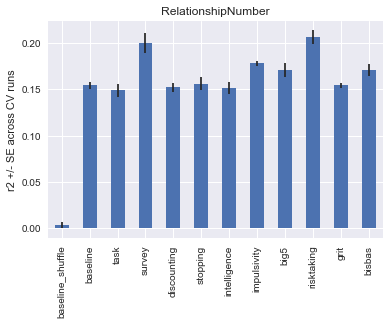

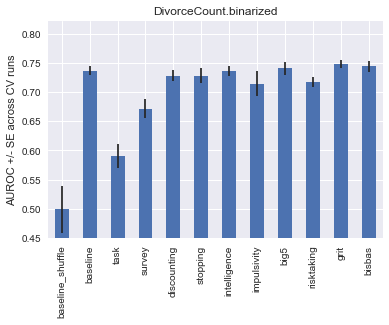

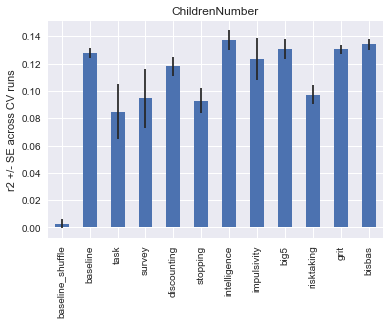

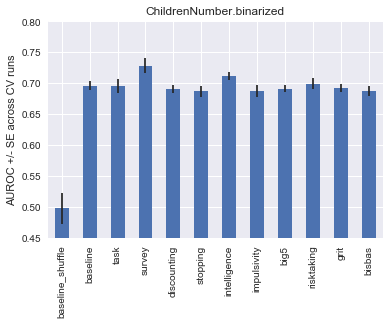

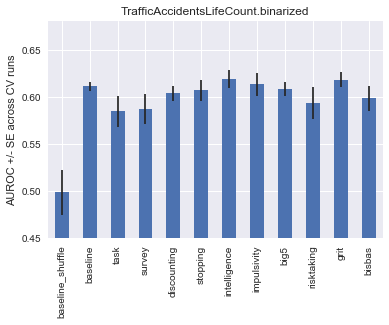

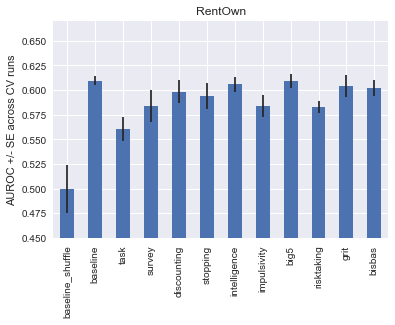

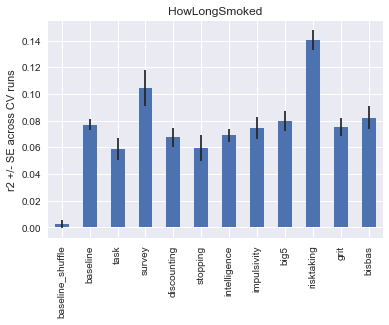

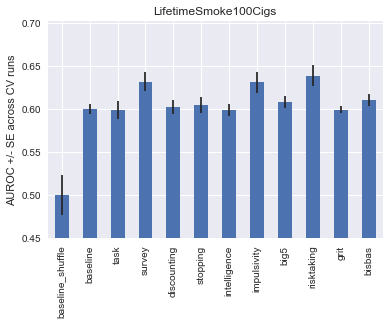

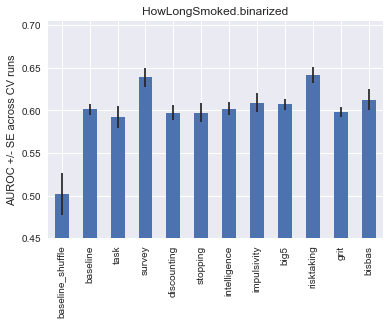

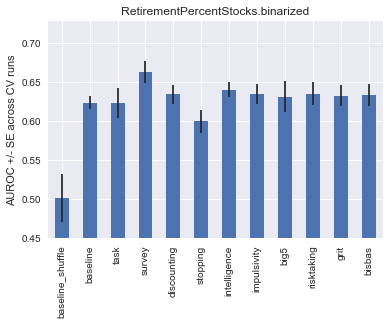

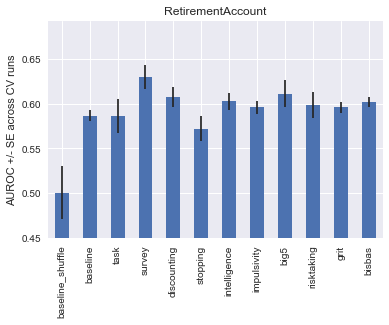

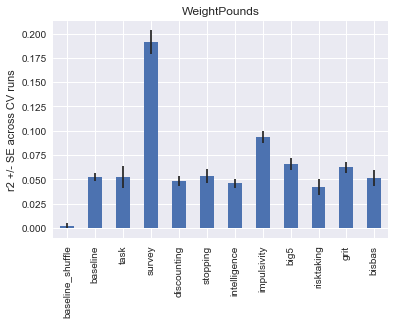

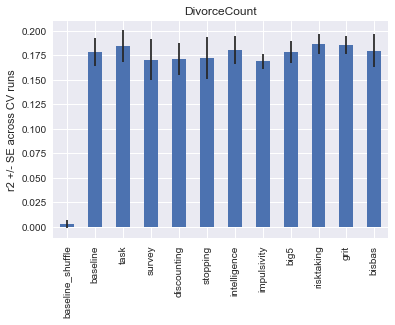

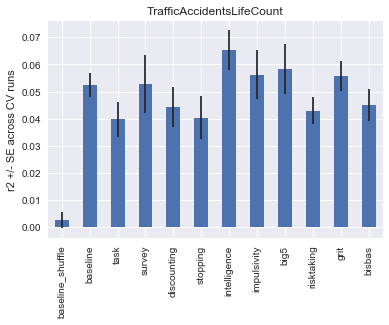

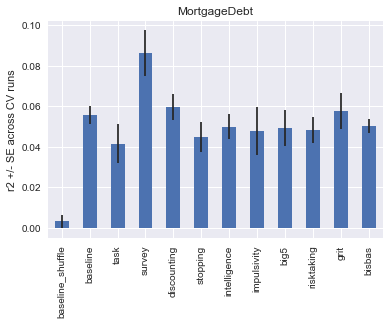

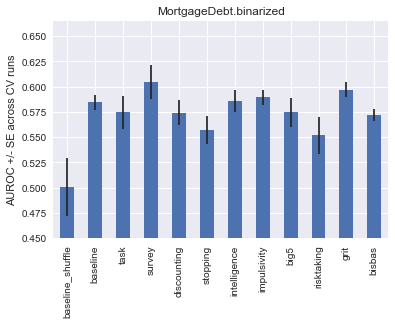

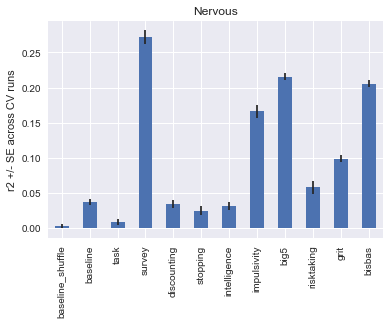

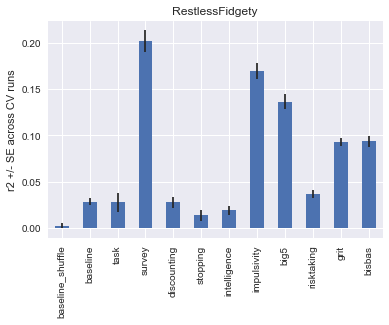

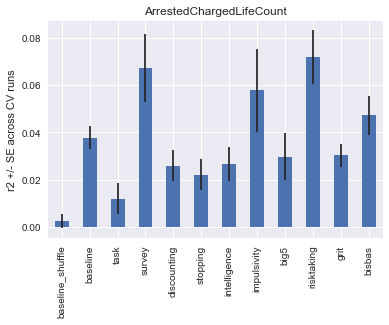

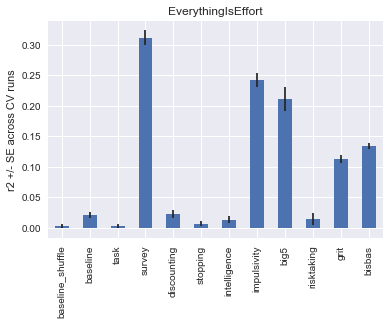

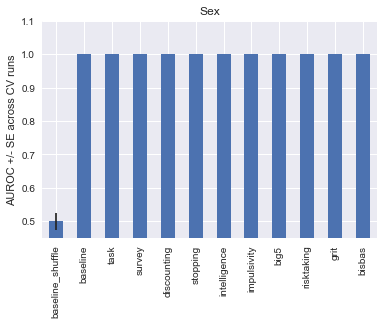

In [18]:
sigp={}
pthresh=0.05
k=('baseline','baseline_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

## Show variables with greater prediction for survey vs. baseline

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AlcoholHowManyDrinksDay,r2,0.189819,0.002329,24.998216,0.220110,0.0,0.0,"[[sensation_seeking_survey.disinhibition, dospert_rt_survey.health_safety, dospert_eb_survey.health_safety.logTr]]"
EverythingIsEffort,r2,0.311615,0.021714,24.782402,0.378363,0.0,0.0,"[[time_perspective_survey.past_negative, ten_item_personality_survey.emotional_stability, mindful_attention_awareness_survey.mindfulness]]"
Nervous,r2,0.271560,0.037181,24.029179,0.332014,0.0,0.0,"[[bis_bas_survey.BIS, ten_item_personality_survey.emotional_stability, time_perspective_survey.past_negative]]"
Hopeless.binarized,AUROC,0.740134,0.541288,22.805050,0.767312,0.0,0.0,"[[time_perspective_survey.past_negative, ten_item_personality_survey.emotional_stability, five_facet_mindfulness_survey.nonjudge]]"
Worthless,r2,0.274290,0.009212,20.829563,0.340033,0.0,0.0,"[[time_perspective_survey.past_negative, five_facet_mindfulness_survey.nonjudge, ten_item_personality_survey.emotional_stability]]"
Hopeless,r2,0.257543,0.013577,19.291398,0.333058,0.0,0.0,"[[time_perspective_survey.past_negative, ten_item_personality_survey.emotional_stability, future_time_perspective_survey.future_time_perspective]]"
DaysHalfLastMonth,r2,0.219263,0.001520,17.822774,0.306949,0.0,0.0,"[[time_perspective_survey.past_negative, bis_bas_survey.BIS, selection_optimization_compensation_survey.optimization.ReflogTr]]"
Worthless.binarized,AUROC,0.735083,0.552161,16.731469,0.770051,0.0,0.0,"[[time_perspective_survey.past_negative, five_facet_mindfulness_survey.nonjudge, brief_self_control_survey.self_control]]"
AlcoholHowOften,r2,0.149591,0.001168,15.188439,0.210296,0.0,0.0,"[[sensation_seeking_survey.disinhibition, time_perspective_survey.past_positive, selection_optimization_compensation_survey.elective_selection]]"
RestlessFidgety,r2,0.201662,0.028649,15.062180,0.285498,0.0,0.0,"[[five_facet_mindfulness_survey.act_with_awareness, time_perspective_survey.past_negative, five_facet_mindfulness_survey.observe]]"


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


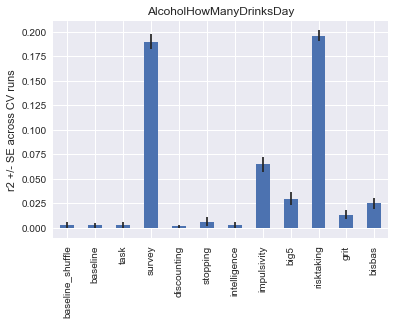

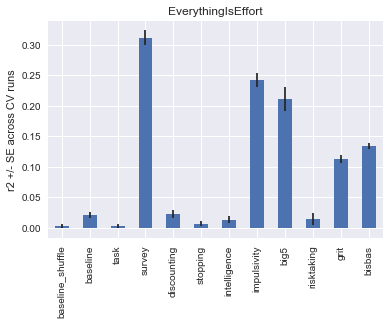

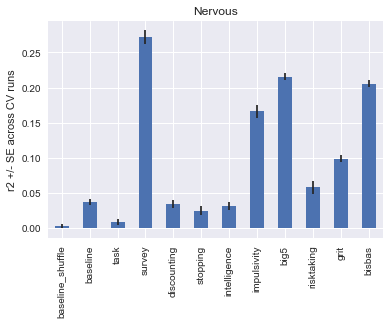

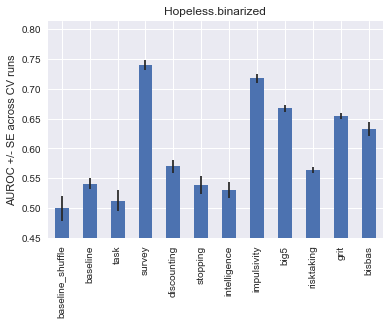

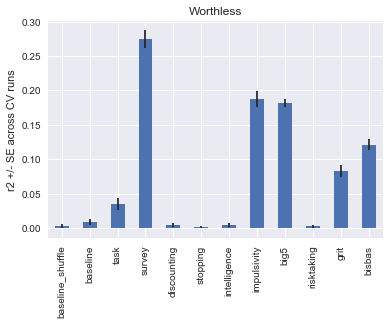

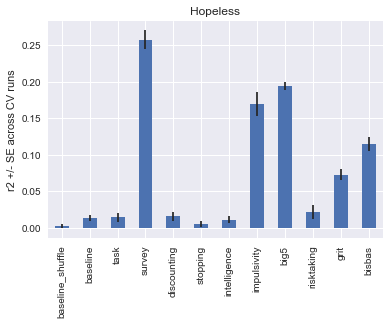

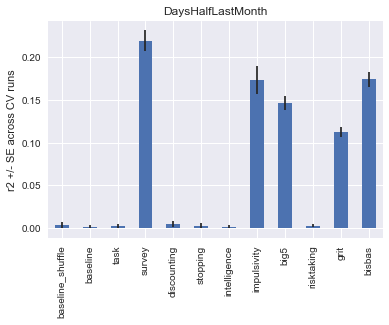

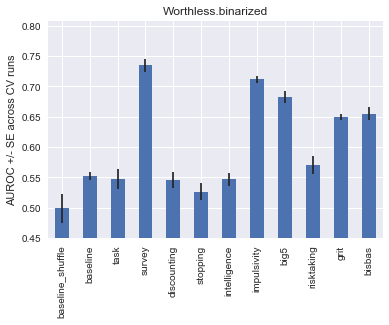

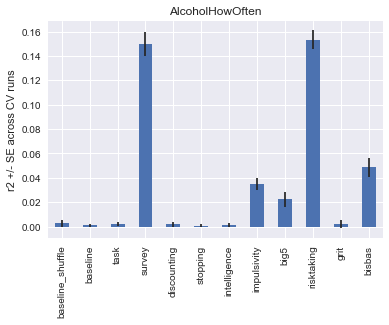

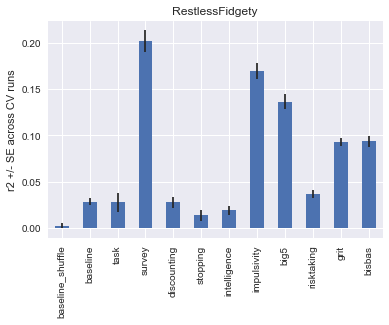

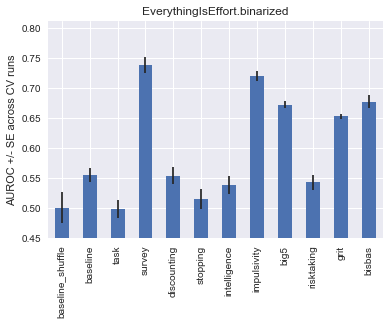

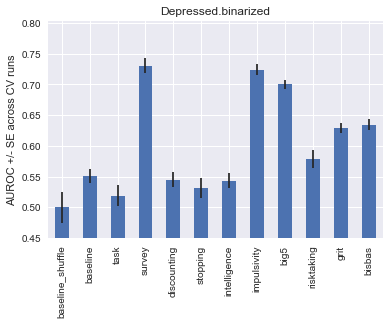

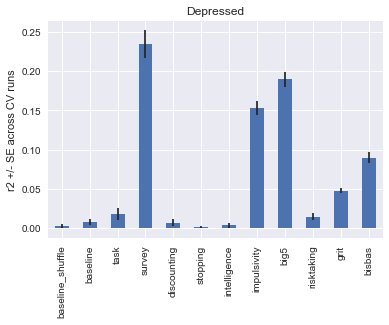

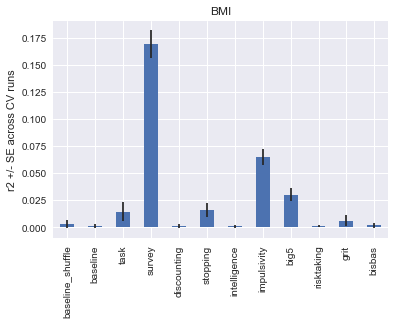

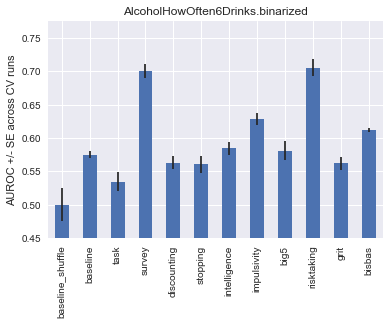

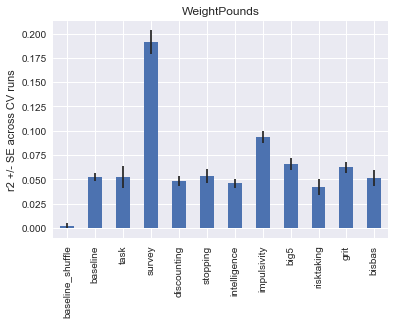

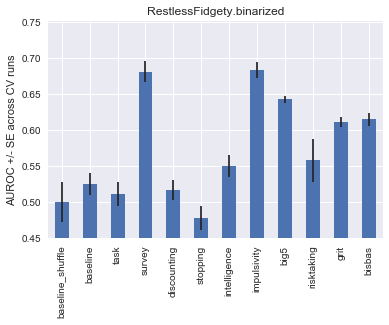

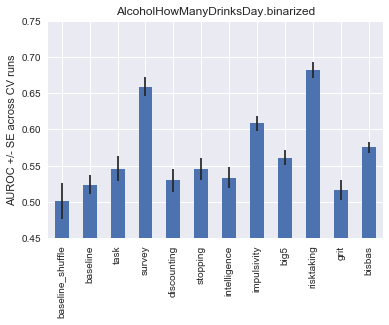

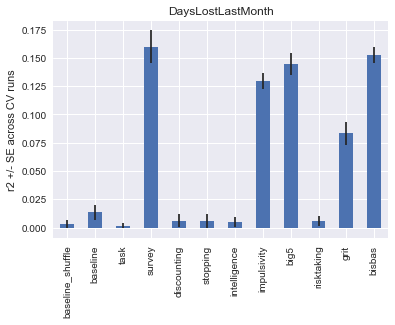

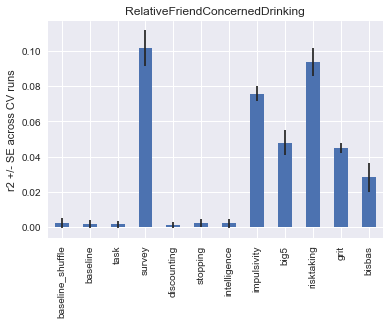

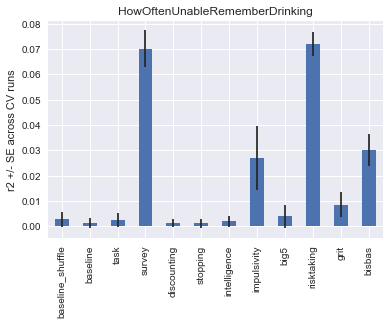

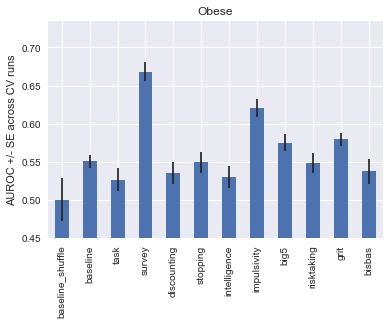

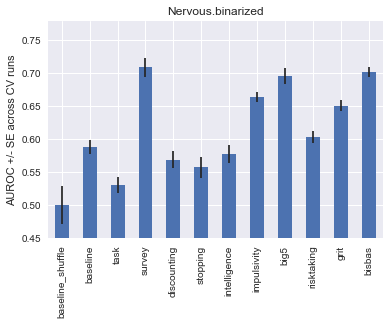

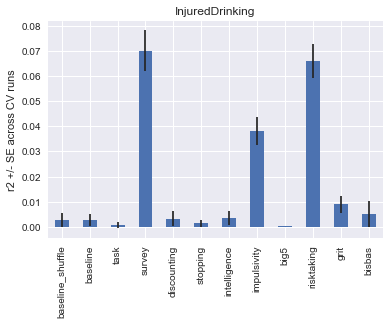

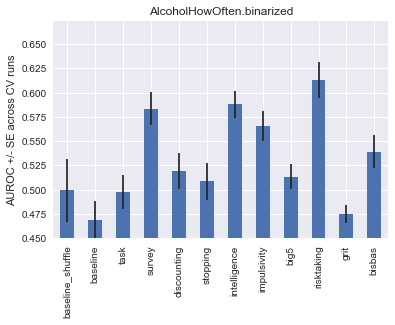

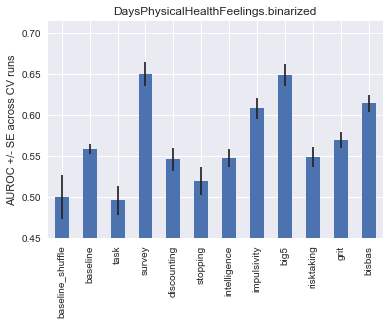

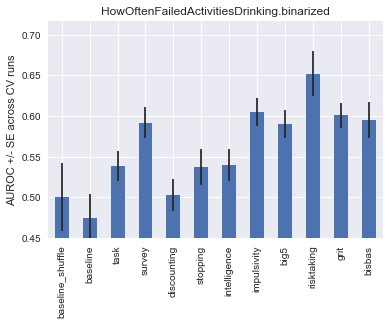

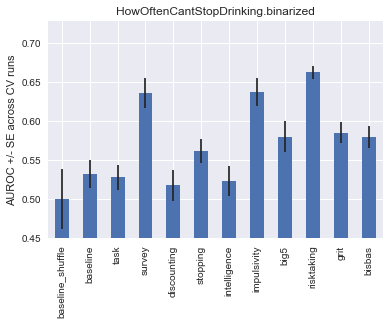

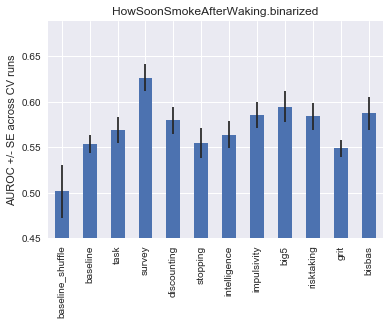

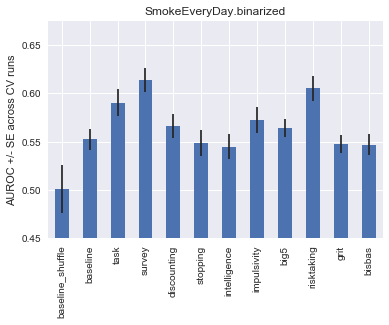

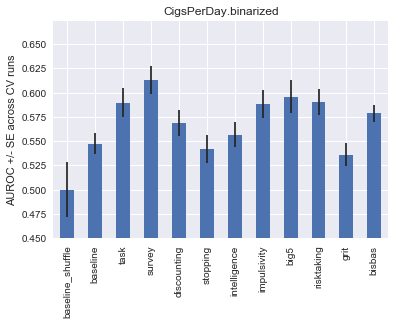

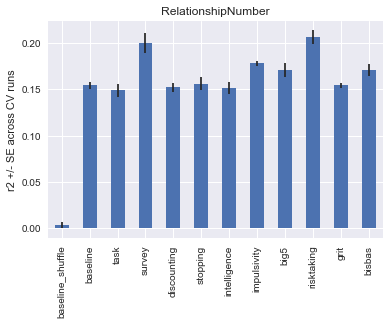

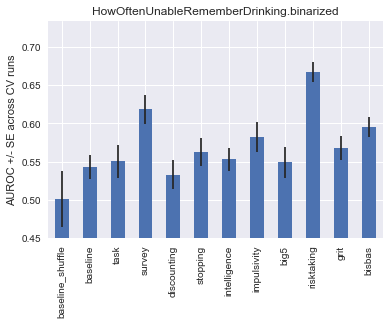

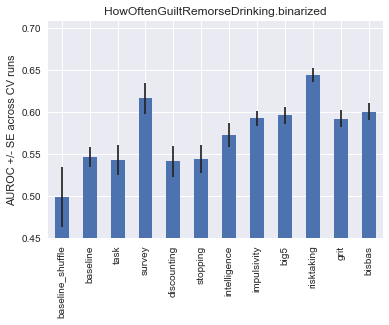

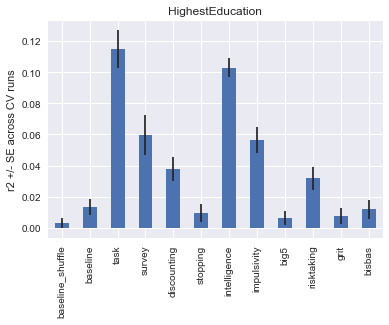

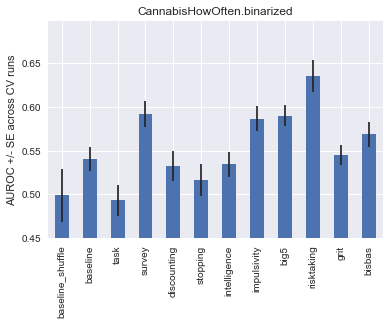

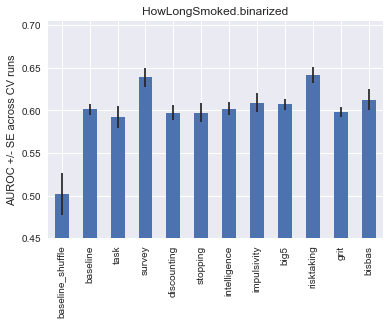

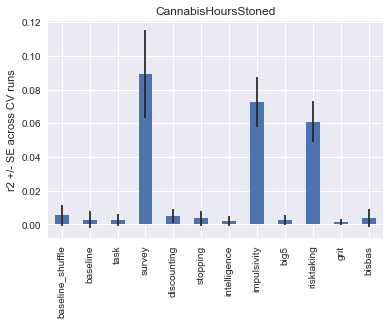

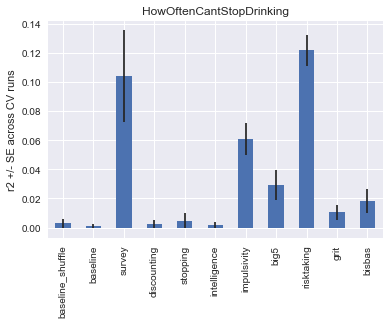

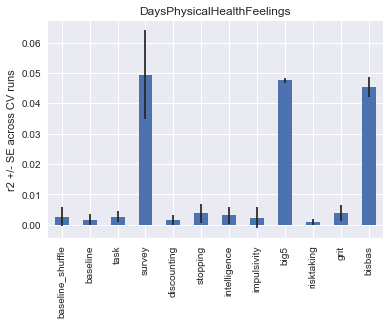

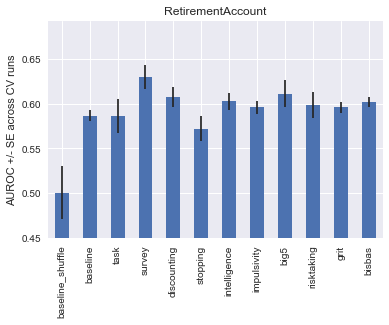

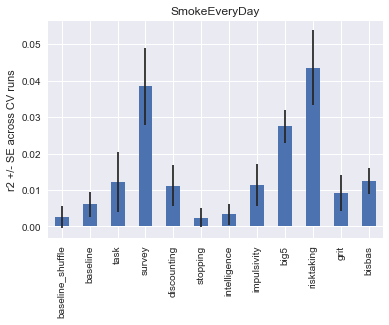

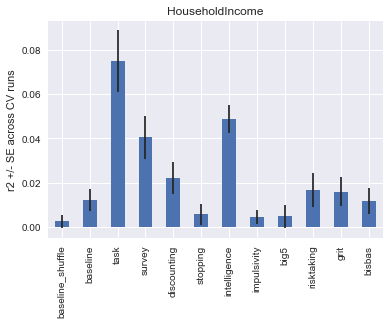

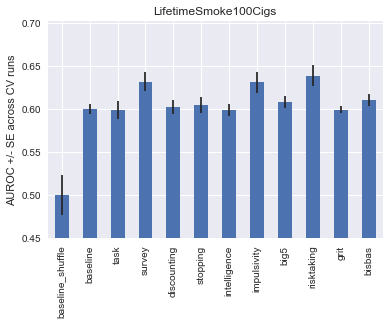

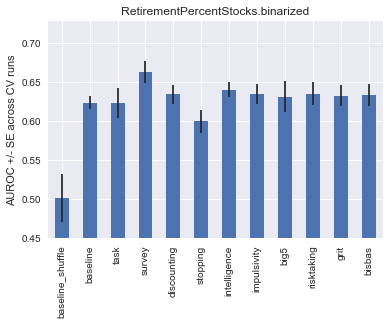

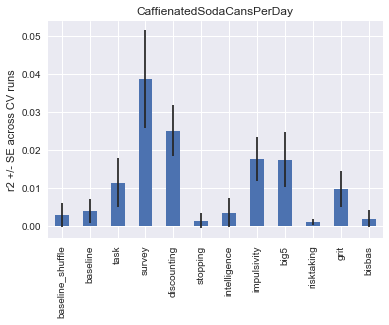

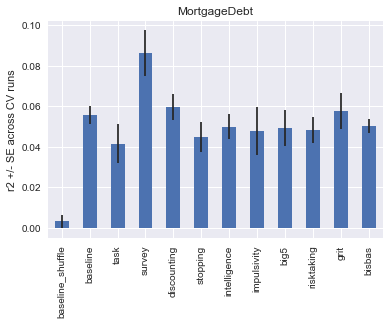

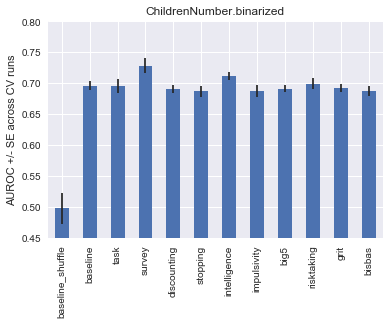

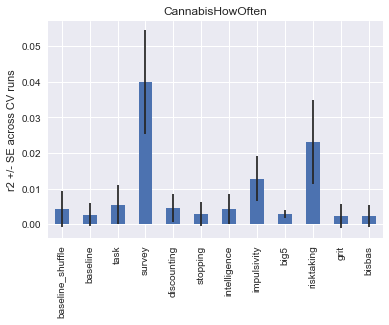

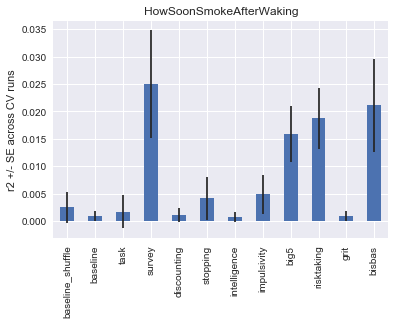

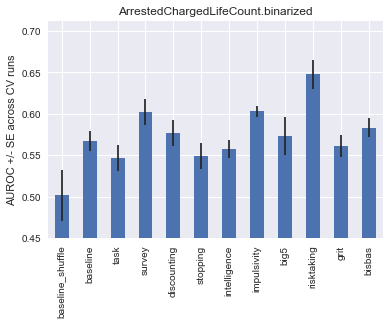

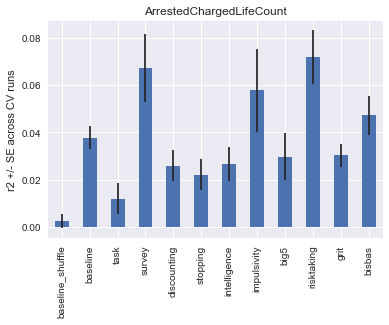

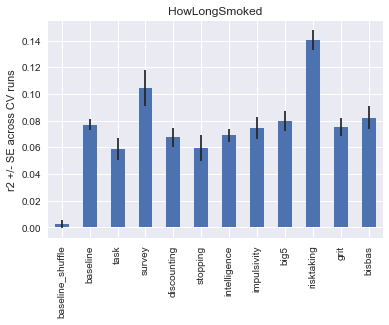

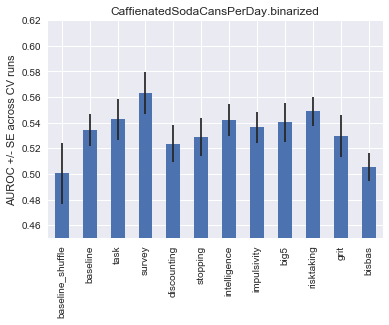

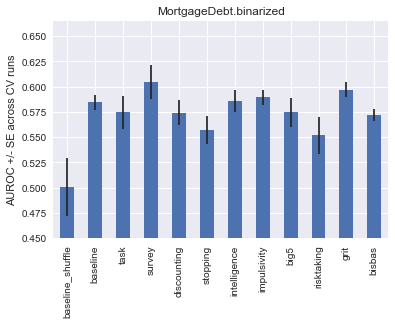

In [19]:
k=('survey','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

## Show variables with greater prediction for task vs. baseline

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
HighestEducation,r2,0.114864,0.013355,8.364080,0.175109,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, writing_task.positive_probability, bickel_titrator.hyp_discount_rate_medium.logTr]]"
HouseholdIncome,r2,0.074815,0.012192,4.556816,0.170281,0.0,0.0,"[[writing_task.positive_probability, cognitive_reflection_survey.correct_proportion, writing_task.neutral_probability]]"
CigsPerDay.binarized,AUROC,0.589675,0.547353,2.875634,0.718212,0.0,0.0,"[[threebytwo.hddm_thresh, adaptive_n_back.hddm_thresh, threebytwo.hddm_non_decision]]"
Worthless,r2,0.034546,0.009212,2.856097,0.099134,0.0,0.0,"[[writing_task.positive_probability, threebytwo.hddm_thresh, attention_network_task.alerting_hddm_drift]]"
SmokeEveryDay.binarized,AUROC,0.590260,0.552413,2.763609,0.720744,0.0,0.0,"[[threebytwo.hddm_thresh, kirby.hyp_discount_rate_large.logTr, tower_of_london.num_extra_moves]]"
BMI,r2,0.014320,0.001398,1.470376,0.123497,0.0,0.0,"[[stim_selective_stop_signal.hddm_thresh.logTr, dietary_decision.health_sensitivity, tower_of_london.num_optimal_solutions]]"
Depressed,r2,0.018049,0.007123,1.416772,0.070017,0.0,0.0,"[[writing_task.positive_probability, threebytwo.hddm_thresh, kirby.hyp_discount_rate_medium.logTr]]"


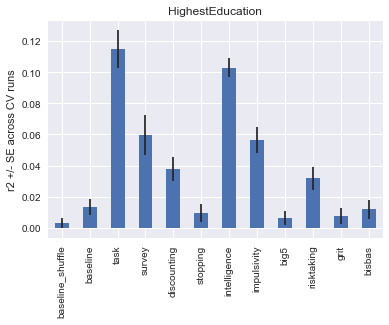

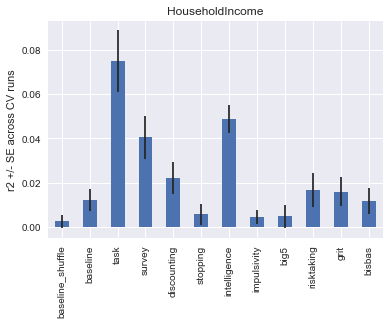

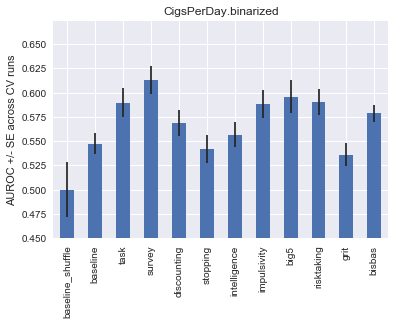

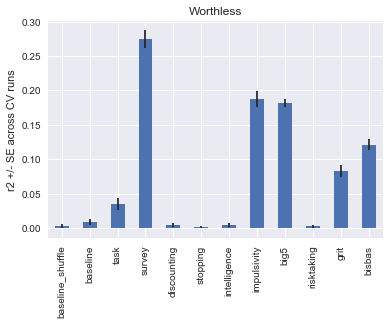

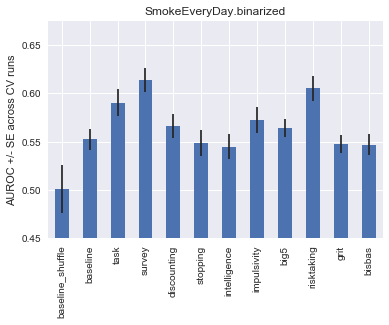

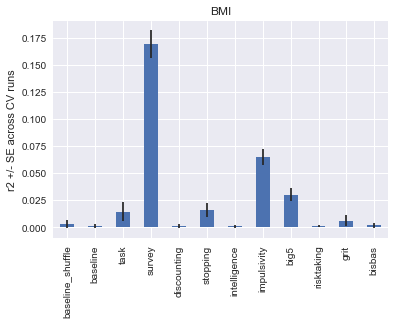

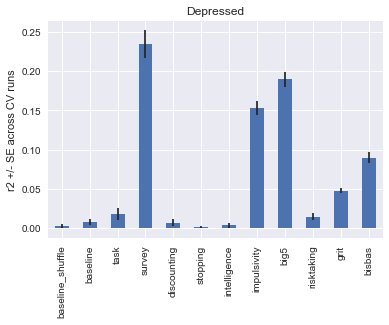

In [20]:
k=('task','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

## Show variables with greater prediction for intelligence vs. baseline

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
HighestEducation,r2,0.103143,0.013355,15.175920,0.122951,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, Age, ravens.score]]"
AlcoholHowOften.binarized,AUROC,0.587700,0.468242,8.606636,NaN,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, ravens.score, Age]]"
HouseholdIncome,r2,0.048821,0.012192,5.681745,0.068739,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, Age, Sex]]"
HowOftenGuiltRemorseDrinking.binarized,AUROC,0.572284,0.546370,1.831753,NaN,0.0,0.0,"[[ravens.score, cognitive_reflection_survey.correct_proportion, Sex]]"
TrafficAccidentsLifeCount,r2,0.065180,0.052393,1.743105,0.087912,0.0,0.0,"[[Age, cognitive_reflection_survey.correct_proportion, ravens.score]]"
RetirementPercentStocks.binarized,AUROC,0.640329,0.623464,1.666863,0.499208,0.0,0.0,"[[Age, cognitive_reflection_survey.correct_proportion, Sex]]"
RetirementAccount,AUROC,0.602456,0.586600,1.613916,0.504068,0.0,0.0,"[[Age, cognitive_reflection_survey.correct_proportion, Sex]]"
CaffieneOtherSourcesDayMG,r2,0.012315,0.005075,1.439068,0.035331,0.0,0.0,"[[ravens.score, Sex, cognitive_reflection_survey.intuitive_proportion]]"
ChildrenNumber,r2,0.137056,0.127762,1.285928,0.163549,0.0,0.0,"[[cognitive_reflection_survey.intuitive_proportion, cognitive_reflection_survey.correct_proportion, Sex]]"
TrafficAccidentsLifeCount.binarized,AUROC,0.619122,0.611300,0.842086,0.614806,0.0,0.0,"[[Age, cognitive_reflection_survey.intuitive_proportion, ravens.score]]"


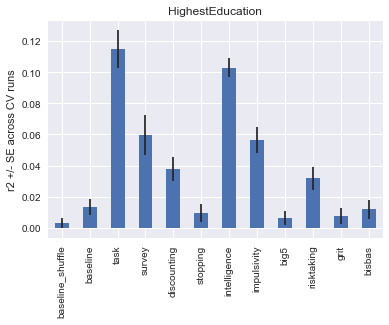

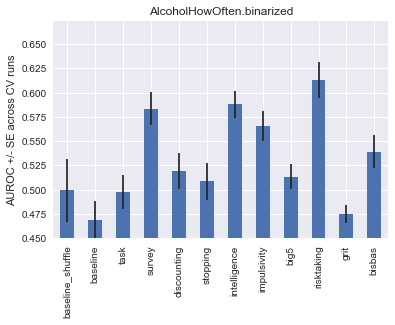

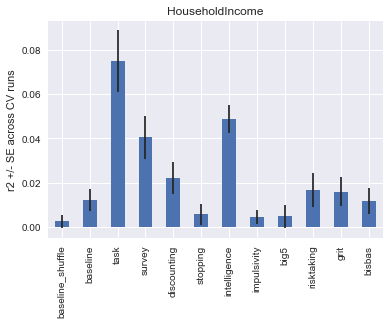

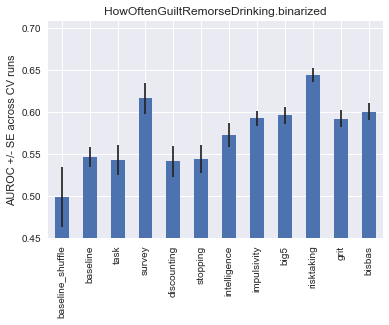

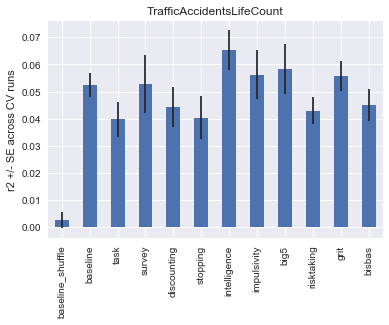

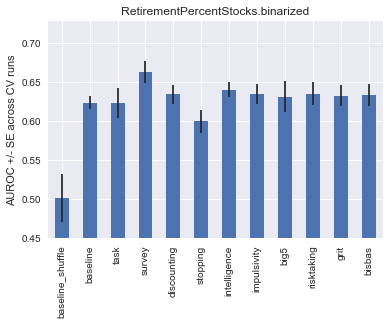

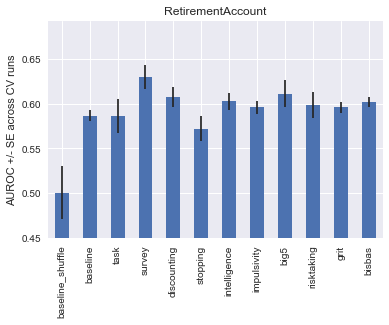

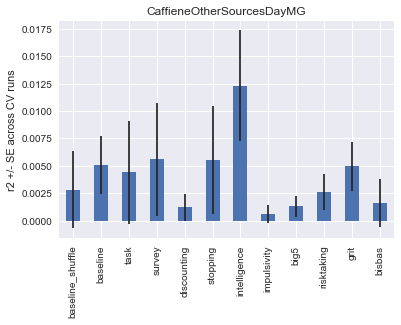

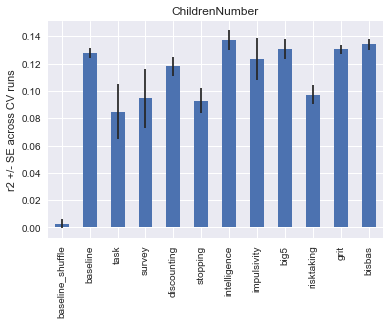

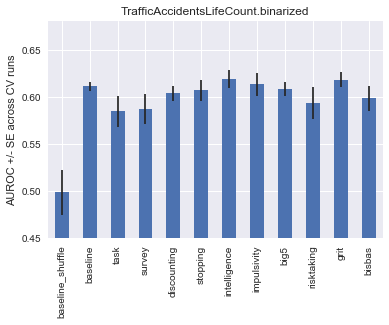

In [21]:
k=('intelligence','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

## Show variables with greater prediction for stopping vs. baseline


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
BMI,r2,0.015769,0.001398,2.250475,0.052047,0.0,0.0,"[[stim_selective_stop_signal.hddm_thresh.logTr, stim_selective_stop_signal.hddm_drift, Age]]"


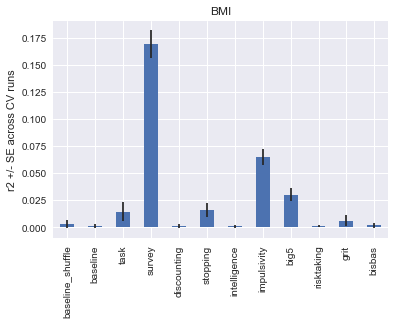

In [22]:
k=('stopping','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

## Show variables with greater prediction for discounting vs. baseline


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
CaffienatedSodaCansPerDay,r2,0.025077,0.003883,3.209520,0.050963,0.0,0.0,"[[bickel_titrator.hyp_discount_rate_large.logTr, kirby.hyp_discount_rate_small.logTr, kirby.hyp_discount_rate_medium.logTr]]"
HighestEducation,r2,0.037678,0.013355,3.179617,0.064696,0.0,0.0,"[[Sex, Age, bickel_titrator.hyp_discount_rate_medium.logTr]]"
Hopeless.binarized,AUROC,0.570405,0.541288,2.726181,0.602704,0.0,0.0,"[[Age, kirby.hyp_discount_rate_medium.logTr, kirby.hyp_discount_rate_large.logTr]]"
RetirementAccount,AUROC,0.607340,0.586600,1.941111,0.523538,0.0,0.0,"[[Age, kirby.hyp_discount_rate_large.logTr, bickel_titrator.hyp_discount_rate_medium.logTr]]"
HowSoonSmokeAfterWaking.binarized,AUROC,0.579397,0.553765,1.757854,0.498508,0.0,0.0,"[[kirby.hyp_discount_rate_large.logTr, Age, discount_titrate.percent_patient]]"


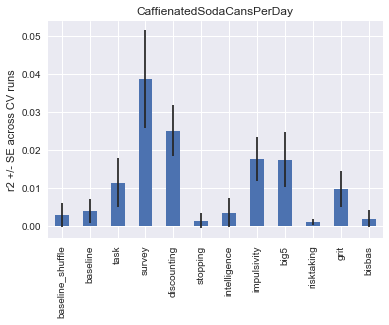

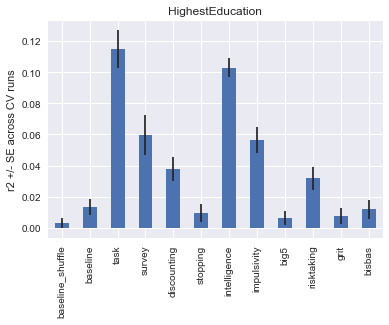

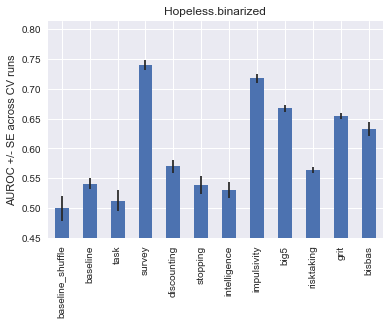

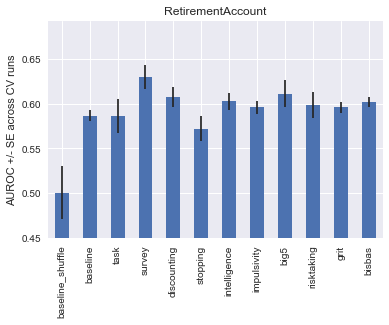

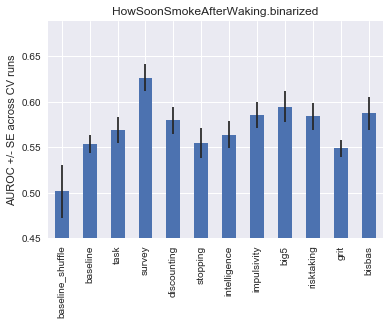

In [23]:
k=('discounting','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

# OLDER

In [24]:
pvalsplot_survey=True
plot_task=True
plt.figure(figsize=(10,16))
offset=5
sortby='baseline'

contdata_sorted=df.query('vartype!="binary"').sort_values(by=sortby)
contdata_sorted=contdata_sorted.loc[pandas.notnull(contdata_sorted['Baseline']),:]

plt.barh(numpy.arange(contdata_sorted.shape[0])*offset,contdata_sorted['Baseline'].values, 
         align='center',linewidth=0.1,color='blue')
plt.yticks(numpy.arange(contdata_sorted.shape[0])*offset+0.8, contdata_sorted.index,
          fontsize=13)
if plot_survey:
    plt.barh(numpy.arange(contdata_sorted.shape[0])*offset+1,contdata_sorted['Survey'].values,
         color='green',align='center',linewidth=0.1)
if plot_task:
    plt.barh(numpy.arange(contdata_sorted.shape[0])*offset+2,contdata_sorted['Task'].values,
         color='red',align='center',linewidth=0.1)
plt.xlabel('Difference in prediction R-squared vs. baseline model')
plt.axis([-0.1,0.3,-2,290])
axis=plt.gca()intelligence','baseline')]

SyntaxError: invalid syntax (<ipython-input-24-d518f956fbe5>, line 22)

In [ ]:
            vars={}
            for k in datasets:
                if not 'r2' in acc[k]:
                    continue
                vars[k]=acc[k]['r2']['scores_cv'].mean().T
            df=pandas.DataFrame(vars,index=[v])
            alldata['r2']=alldata['r2'].append(df)

            vars={}
            for k in datasets:
                if not 'MAE' in acc[k]:
                    continue
                vars[k]=acc[k]['MAE']['scores_cv'].mean().T
            df=pandas.DataFrame(vars,index=[v])
            alldata['MAE']=alldata['MAE'].append(df)
        else:
            vars={}
            for k in datasets:
                if not 'AUROC' in acc[k]:
                    continue
                vars[k]=acc[k]['AUROC']['scores_cv'].mean().T
            df=pandas.DataFrame(vars,index=[v])
            alldata['AUROC']=alldata['AUROC'].append(df)
   


In [ ]:
alldata=[]


task_vs_survey={}
task_vs_baseline={}
survey_vs_baseline={}
#allvars=list(set(allvars))
allvars=list(bp.demogdata.columns)
allvars.sort()
tsvars=[]
for v in allvars:
    if not v in acc['survey'] or not v in acc['task']:
        continue
    task_vs_survey[v]=tt=scipy.stats.ttest_ind(numpy.array(acc['survey'][v]),
                            numpy.array(acc['task'][v]),equal_var=False)
    tsvars.append(v)
    if v in acc['baseline']:
        task_vs_baseline[v]=tt=scipy.stats.ttest_ind(numpy.array(acc['baseline'][v]),
                                numpy.array(acc['task'][v]),equal_var=False)
        survey_vs_baseline[v]=tt=scipy.stats.ttest_ind(numpy.array(acc['baseline'][v]),
                                numpy.array(acc['survey'][v]),equal_var=False)

#if 'Age' in tsvars:
#    tsvars.remove('Age')
#if 'Sex' in tsvars:
#    tsvars.remove('Sex')
# also remove the K6 psychological variables since they overlap with 
# survey items
#for v in ['Depressed','Worthless','RestlessFidgety','Nervous','Hopeless','EverythingIsEffort']:
#    if v in tsvars:
#        tsvars.remove(v)

cutoffs={}

datatypes=list(acc.keys())

meanimp={}
for v in tsvars:
    data={}  
    means={}
    pct95={}
    meanimp[v]={}
    for dt in datatypes:
        if v in acc[dt]:
            if bp.data_models[v]=='binary':
                data[dt]=numpy.array(acc[dt][v])
            else:
                data[dt]=numpy.array(acc[dt][v])**2
            means[dt]=numpy.mean(data[dt])
            pct95[dt]=numpy.percentile(data[dt],95)
            meanimp[v][dt]=numpy.mean(numpy.vstack(features[dt][v]),0)
        else:
            data[dt]=None
            means[dt]=numpy.nan
            pct95[dt]=numpy.nan
            meanimp[v][dt]=None
    
    if v in task_vs_baseline:
        task_baseline_pval=task_vs_baseline[v].pvalue
        if means['task']<means['baseline']:
            task_baseline_pval=1-task_baseline_pval
    
    alldata.append([v,bp.data_models[v],pct95['baseline_shuffle'],
                        means['baseline'],pct95['baseline'],
                        means['task'],task_baseline_pval,
                        means['survey'],
                        task_vs_survey[v].pvalue])
    
df=pandas.DataFrame(alldata,columns=['Variable','vartype','ShuffleCutoff','Baseline',
                                     'Baseline95pct',
                                    'Task','TaskVsBaselineP',
                                     'Survey','SurveyVsTaskP'])
df['Task-Baseline']=df.Task - df.Baseline
df['Survey-Baseline']=df.Survey-df.Baseline
df['Baseline95pctDiff']=df.Baseline95pct-df.Baseline
df.index=df.Variable
del df['Variable']
display(df)
bmi=df[df.index=='BMI']


In [ ]:
contdata_sorted=df.query('vartype!="binary"').sort_values(by='Task')
contdata_sorted

In [ ]:
plot_survey=True
plot_task=True
plt.figure(figsize=(10,16))
offset=5
sortby='Survey'
contdata_sorted=df.query('vartype!="binary"').sort_values(by=sortby)
contdata_sorted=contdata_sorted.loc[pandas.notnull(contdata_sorted['Baseline']),:]

plt.barh(numpy.arange(contdata_sorted.shape[0])*offset,contdata_sorted['Baseline'].values, 
         align='center',linewidth=0.1,color='blue')
plt.yticks(numpy.arange(contdata_sorted.shape[0])*offset+0.8, contdata_sorted.index,
          fontsize=13)
if plot_survey:
    plt.barh(numpy.arange(contdata_sorted.shape[0])*offset+1,contdata_sorted['Survey'].values,
         color='green',align='center',linewidth=0.1)
if plot_task:
    plt.barh(numpy.arange(contdata_sorted.shape[0])*offset+2,contdata_sorted['Task'].values,
         color='red',align='center',linewidth=0.1)
plt.xlabel('Difference in prediction R-squared vs. baseline model')
plt.axis([-0.1,0.3,-2,290])
axis=plt.gca()

In [ ]:
def get_importances(v,dt,meanimp):
    print(dt,'importances for:',v)
    tmpbp=bp.load_behav_data(dt)
    varnames=list(bp.behavdata.columns)
    
    imp=meanimp[v][dt]
    idx=numpy.argsort(imp)[::-1]
    for i in range(3):
        print(varnames[idx[i]],imp[idx[i]])
    idx=numpy.argsort(imp)
    for i in range(2,-1,-1):
        print(varnames[idx[i]],imp[idx[i]])

get_importances('BMI','survey',meanimp)
get_importances('BMI','task',meanimp)

In [ ]:
for c in bp.behavdata.columns:
    print(c)


In [ ]:
plot_survey=True
plt.figure(figsize=(8,6))
offset=3.5
contdata_sorted=df.query('vartype=="binary"').sort_values(by='Task-Baseline')
contdata_sorted=contdata_sorted.loc[pandas.notnull(contdata_sorted['Task-Baseline']),:]
plt.barh(numpy.arange(contdata_sorted.shape[0])*offset,contdata_sorted['Task-Baseline'].values, 
         align='center',linewidth=0.1,color='blue')
plt.yticks(numpy.arange(contdata_sorted.shape[0])*offset+0.8, contdata_sorted.index,
          fontsize=13)
if plot_survey:
    plt.barh(numpy.arange(contdata_sorted.shape[0])*offset+1,contdata_sorted['Survey-Baseline'].values,
         color='green',align='center')
plt.xlabel('Difference in prediction AUC-ROC vs baseline model')
plt.axis([-.2,0.25,-1,40])
axis=plt.gca()

OLDER Stuff below

In [ ]:



basekeys=list(baseline[0].keys())
basekeys.sort()
exceedence=25
varthresh=0.02
printvars=False
print_surveyvars=True

print("variables with task > baseline by at least %d percent and > %d pct variance:"%(exceedence,100*varthresh))
dfdata=[]
alldata=[]
keys=[]
for v in basekeys:
    if not v in task[0]:
        continue
    if v in ['Age','Sex']:
        continue
    if bp.data_models[v]=='binary':
        alldata.append([v,bp.data_models[v],baseline[0][v],task[0][v],survey[0][v]])
    else: # convert to r-squared
        alldata.append([v,bp.data_models[v],baseline[0][v]**2,task[0][v]**2,survey[0][v]**2])
    if 1: #task[0][v]**2>(baseline[0][v]**2)*(1+exceedence/100) and task[0][v]**2>varthresh:
        print('')
        print('%s (%s)'%(v,bp.data_models[v]),
              'baseline=%0.3f, task=%0.3f, survey=%0.3f, pct diff=%0.3f'%(baseline[0][v]**2,
                                                        task[0][v]**2,survey[0][v]**2,
                                                       (task[0][v]**2-baseline[0][v]**2)))
        if printvars:
            # print strongest predctive variables
            lasso_coefs=task[1][v][0,:]
            idx=numpy.argsort(numpy.abs(lasso_coefs))[::-1]
            for i in range(6):
                if lasso_coefs[idx[i]]!=0:
                    print(taskvars[idx[i]],lasso_coefs[idx[i]])
        if print_surveyvars:
            # print strongest predctive variables
            lasso_coefs=survey[1][v][0,:]
            idx=numpy.argsort(numpy.abs(lasso_coefs))[::-1]
            for i in range(6):
                if lasso_coefs[idx[i]]!=0:
                    print(surveyvars[idx[i]],lasso_coefs[idx[i]])
 

In [ ]:
alldata=pandas.DataFrame(alldata,columns=['variable','vartype','baseline','task','survey'])
alldata.index=alldata.variable
alldata['diff']=alldata.task - alldata.baseline
print(alldata.shape)
display(alldata.query('diff<=0').sort('diff'))
print('%d variables with diff <= 0'%alldata.query('diff<=0').shape[0])
display(alldata.query('diff>0').sort('diff'))
print('%d variables with diff > 0'%alldata.query('diff>0').shape[0])
alldata.query('vartype!="binary"')['diff'].hist(bins=20)
plt.xlabel('R2 Difference between task and baseline model')
plt.ylabel('Frequency')

In [ ]:
plot_survey=True
plt.figure(figsize=(10,16))
offset=3.5
contdata_sorted=alldata.query('vartype!="binary"').sort_values(by='task')
plt.barh(numpy.arange(contdata_sorted.shape[0])*offset,contdata_sorted['baseline'].values, 
         align='center',linewidth=0.1,color='blue')
plt.yticks(numpy.arange(contdata_sorted.shape[0])*offset+0.8, contdata_sorted.index,
          fontsize=13)
plt.barh(numpy.arange(contdata_sorted.shape[0])*offset+1,contdata_sorted['task'].values,
         color='green',align='center')
if plot_survey:
    plt.barh(numpy.arange(contdata_sorted.shape[0])*offset+2,contdata_sorted['survey'].values,
         color='red',align='center')
plt.xlabel('R-squared')
plt.axis([0,0.5,-1,190])
axis=plt.gca()
#axis.set_xticklabels(labels, fontsize='small').

In [ ]:
plt.figure(figsize=(10,8))
binarydata_sorted=alldata.query('vartype=="binary"').sort('task')
plt.barh(numpy.arange(binarydata_sorted.shape[0])*offset,binarydata_sorted['baseline'].values, 
         align='center',linewidth=0.1,color='blue')
plt.yticks(numpy.arange(binarydata_sorted.shape[0])*offset+0.8, binarydata_sorted.index,
          fontsize=13)
plt.barh(numpy.arange(binarydata_sorted.shape[0])*offset+1,binarydata_sorted['task'].values,
         color='green',align='center')
plt.barh(numpy.arange(binarydata_sorted.shape[0])*offset+2,binarydata_sorted['survey'].values,
         color='red',align='center')
plt.xlabel('Area under ROC curve')
plt.axis([0.5,1,-1,40])
axis=plt.gca()
#axis.set_xticklabels(labels, fontsize='small').

OLDER STUFF BELOW

In [ ]:
pvals={}
pvals_fdr={}
pvals_fwe={}

results={}
for clf in ['lasso']: #,'forest']:
    if not clf in pvals:
        pvals[clf]={}
        pvals_fdr[clf]={}
        pvals_fwe[clf]={}
        results[clf]={}
    for ds in ['all','survey','task']:
        if not ds in pvals[clf]:
            pvals[clf][ds]={}
            pvals_fdr[clf][ds]={}
            pvals_fwe[clf][ds]={}
            results[clf][ds]=[]
        # load data
        truedata,permuted=pickle.load(open('regression_%s_%s_data.pkl'%(clf,ds),'rb'))
        truedata_classification,permuted_classification=pickle.load(open('prediction_%s_%s_data.pkl'%(clf,ds),'rb'))
       # put into a matrix
        keys=list(truedata[0].keys())
        keys.sort()

        permuted_data=numpy.zeros((len(keys),len(permuted[list(permuted.keys())[0]])))

        for i,k in enumerate(keys):
            permuted_data[i,:]=permuted[list(permuted.keys())[i]]
        # FWE max cutoff
        perm_max=numpy.nanmax(permuted_data,0)
        cutoff=scipy.stats.scoreatpercentile(perm_max,95)
        print(clf,ds,'cutoff=%0.3f'%cutoff)
        # get individual variable pvals
        pvals[clf][ds]=[]
        pvals_fwe[clf][ds]=[]
        for i in range(permuted_data.shape[0]):
            if not keys[i] in truedata_classification[0]:
                truedata_classification[0][keys[i]]=numpy.nan
            data_nonan=[x for x in permuted_data[i,:] if not numpy.isnan(x)]
            pvals[clf][ds].append((100-scipy.stats.percentileofscore(data_nonan,truedata[0][keys[i]]))/100.)
            pvals_fwe[clf][ds].append((100-scipy.stats.percentileofscore(perm_max,truedata[0][keys[i]]))/100.)
        pvals[clf][ds]=[x if not numpy.isnan(x) else 0.5 for x in pvals[clf][ds] ]
        _,pvals_fdr[clf][ds],_,_=multipletests(pvals[clf][ds],method='fdr_bh')
        
        for i in range(permuted_data.shape[0]):
            if pvals_fwe[clf][ds][i]<=0.05:
                results[clf][ds].append([keys[i],
                                '%f'%truedata[0][keys[i]],
                                '%f'%truedata_classification[0][keys[i]],
                                '%f'%pvals[clf][ds][i],
                                '%f'%pvals_fdr[clf][ds][i],
                                '%f'%pvals_fwe[clf][ds][i]])

In [ ]:
for clf in ['lasso']: #,'forest']:
    for ds in ['all','survey','task']:
        print(ds)
        results_df=pandas.DataFrame(results[clf][ds],columns=['Variable','r-squared','class acc','p(unc)','p(FDR)','p(FWE)'])
        display(results_df)